In [1]:
import os
import glob

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
tf.random.set_seed(1234)


2024-06-21 04:29:01.304109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 04:29:01.304202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 04:29:01.478767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DIR = tf.keras.utils.get_file(
    "dataset2019.zip",
    "http://download.cs.stanford.edu/downloads/completion3d/dataset2019.zip",
    extract=True,
)
DATA_DIR = os.path.join (os.path.dirname(DATA_DIR),"shapenet")

1585860897/1585860897 ━━━━━━━━━━━━━━━━━━━━ 300s 0us/step


In [3]:
import re
import h5py
import numpy as np

def read_point_cloud_from_h5_file(file_path):
    with h5py.File(file_path, 'r') as file:
        
        point_cloud_data = file['data'][:]
    return point_cloud_data

In [21]:
import os
import h5py
import numpy as np
from tqdm import tqdm

def load_h5_file(file_path, dataset_name='data'):
    """Load point cloud data from an .h5 file."""
    with h5py.File(file_path, 'r') as file:
        data = file[dataset_name][:]
    return data

def load_dataset(base_dir, categories, dataset_name='data'):
    """Load partial and gt datasets from the given base directory."""
    partials = []
    gts = []

    for category in categories:
        partial_dir = os.path.join(base_dir, 'partial', category)
        gt_dir = os.path.join(base_dir, 'gt', category)

        # Check if the directories exist
        if not os.path.exists(partial_dir):
            print(f"Partial directory does not exist: {partial_dir}")
            continue
        if not os.path.exists(gt_dir):
            print(f"GT directory does not exist: {gt_dir}")
            continue

        partial_files = sorted([f for f in os.listdir(partial_dir) if f.endswith('.h5')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.h5')])

        for p_file, gt_file in tqdm(zip(partial_files, gt_files), total=len(partial_files), desc=f"Loading {category}"):
            partial_path = os.path.join(partial_dir, p_file)
            gt_path = os.path.join(gt_dir, gt_file)

            partial_data = load_h5_file(partial_path, dataset_name)
            gt_data = load_h5_file(gt_path, dataset_name)

            partials.append(partial_data)
            gts.append(gt_data)

    return np.array(partials), np.array(gts)

# Example usage
base_dir = os.path.join(DATA_DIR , "train")
categories = ['02691156', '03636649', '02933112', '02958343', '03001627' , '04256520' , '04379243' , '04530566']  # Replace with your actual category names
partial_dataset, gt_dataset = load_dataset(base_dir, categories)
print(f'Loaded {len(partial_dataset)} partial point clouds and {len(gt_dataset)} ground truth point clouds.')


Loading 04530566: 100%|██████████| 1689/1689 [00:01<00:00, 983.45it/s] 


Loaded 28974 partial point clouds and 28974 ground truth point clouds.


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# Encoder definition
class PointNetEncoder(nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1024)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2)[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Decoder definition
class PointCloudDecoder(nn.Module):
    def __init__(self, num_points):
        super(PointCloudDecoder, self).__init__()
        self.num_points = num_points
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 3, self.num_points)
        return x

# Model combining encoder and decoder
class PointCompletionNet(nn.Module):
    def __init__(self, num_points=2048):
        super(PointCompletionNet, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointCloudDecoder(num_points)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose to (batch_size, 3, num_points)
        features = self.encoder(x)
        reconstructed = self.decoder(features)
        return reconstructed.transpose(1, 2)  # Transpose back to (batch_size, num_points, 3)

# Dataset class
class PointCloudDataset(Dataset):
    def __init__(self, partial_data, gt_data):
        self.partial_data = partial_data.astype(np.float32)
        self.gt_data = gt_data.astype(np.float32)

    def __len__(self):
        return len(self.partial_data)

    def __getitem__(self, idx):
        partial = self.partial_data[idx]
        gt = self.gt_data[idx]
        return partial, gt

# Chamfer Distance (simplified version)
def chamfer_distance(pred, gt):
    batch_size, num_points, _ = pred.size()
    pred = pred.unsqueeze(1).repeat(1, num_points, 1, 1)
    gt = gt.unsqueeze(2).repeat(1, 1, num_points, 1)
    dist = torch.norm(pred - gt, dim=-1)
    dist1 = dist.min(dim=2)[0]
    dist2 = dist.min(dim=1)[0]
    return dist1.mean(dim=1) + dist2.mean(dim=1)

# Load your datasets
partial_dataset = partial_dataset
gt_dataset = gt_dataset

# Create DataLoader
train_dataset = PointCloudDataset(partial_dataset, gt_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Hyperparameters and model initialization
num_points = 2048
model = PointCompletionNet(num_points).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 25

# Training loop with progress bar
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Initialize the progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for partial, complete in train_loader:
            partial, complete = partial.cuda(), complete.cuda()
            optimizer.zero_grad()

            reconstructed = model(partial)
            loss = chamfer_distance(reconstructed, complete).mean()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss/len(train_loader))
            pbar.update(1)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch 1/25: 100%|██████████| 906/906 [02:08<00:00,  7.05batch/s, loss=0.0886]


Epoch [1/25], Loss: 0.0886


Epoch 2/25: 100%|██████████| 906/906 [02:09<00:00,  7.02batch/s, loss=0.064]  


Epoch [2/25], Loss: 0.0640


Epoch 3/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0607] 


Epoch [3/25], Loss: 0.0607


Epoch 4/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0589] 


Epoch [4/25], Loss: 0.0589


Epoch 5/25: 100%|██████████| 906/906 [02:09<00:00,  6.99batch/s, loss=0.0574] 


Epoch [5/25], Loss: 0.0574


Epoch 6/25: 100%|██████████| 906/906 [02:09<00:00,  6.99batch/s, loss=0.0563] 


Epoch [6/25], Loss: 0.0563


Epoch 7/25: 100%|██████████| 906/906 [02:09<00:00,  6.99batch/s, loss=0.0554] 


Epoch [7/25], Loss: 0.0554


Epoch 8/25: 100%|██████████| 906/906 [02:09<00:00,  6.99batch/s, loss=0.0547] 


Epoch [8/25], Loss: 0.0547


Epoch 9/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0538] 


Epoch [9/25], Loss: 0.0538


Epoch 10/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0533] 


Epoch [10/25], Loss: 0.0533


Epoch 11/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0528] 


Epoch [11/25], Loss: 0.0528


Epoch 12/25: 100%|██████████| 906/906 [02:09<00:00,  6.99batch/s, loss=0.0522] 


Epoch [12/25], Loss: 0.0522


Epoch 13/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.052]  


Epoch [13/25], Loss: 0.0520


Epoch 14/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0516] 


Epoch [14/25], Loss: 0.0516


Epoch 15/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0513] 


Epoch [15/25], Loss: 0.0513


Epoch 16/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0509] 


Epoch [16/25], Loss: 0.0509


Epoch 17/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0506] 


Epoch [17/25], Loss: 0.0506


Epoch 18/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0504] 


Epoch [18/25], Loss: 0.0504


Epoch 19/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0502] 


Epoch [19/25], Loss: 0.0502


Epoch 20/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0499] 


Epoch [20/25], Loss: 0.0499


Epoch 21/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0497] 


Epoch [21/25], Loss: 0.0497


Epoch 22/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0495] 


Epoch [22/25], Loss: 0.0495


Epoch 23/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0494] 


Epoch [23/25], Loss: 0.0494


Epoch 24/25: 100%|██████████| 906/906 [02:09<00:00,  7.01batch/s, loss=0.0492] 


Epoch [24/25], Loss: 0.0492


Epoch 25/25: 100%|██████████| 906/906 [02:09<00:00,  7.00batch/s, loss=0.0491] 

Epoch [25/25], Loss: 0.0491


In [41]:
# Function to load test dataset
def load_test_dataset(base_dir):
    test_data = []
    file_paths = []

    test_partial_dir = os.path.join(base_dir, 'test', 'partial' , 'all')

    # Iterate through each file in the test/partial directory
    for file_name in os.listdir(test_partial_dir):
        file_path = os.path.join(test_partial_dir, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.h5'):
            file_paths.append(file_path)

            # Read point cloud data from .h5 file
            with h5py.File(file_path, 'r') as file:
                data = np.array(file['data'][:])  # Adjust based on your dataset structure
                test_data.append(data)

    return np.array(test_data), file_paths

# Example usage
base_dir = DATA_DIR
test_dataset, test_file_paths = load_test_dataset(base_dir)

# Check the shape of test dataset
print("Test dataset shape:", test_dataset.shape)  # Should be (num_samples, num_points, 3)

Test dataset shape: (1184, 2048, 3)


In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class PointCloudDataset2(Dataset):
    def __init__(self, partial_data, gt_data=None):
        self.partial_data = partial_data.astype(np.float32)
        self.gt_data = gt_data.astype(np.float32) if gt_data is not None else None

    def __len__(self):
        return len(self.partial_data)

    def __getitem__(self, idx):
        partial = self.partial_data[idx]
        if self.gt_data is not None:
            gt = self.gt_data[idx]
            return partial, gt
        else:
            return partial

# Load the partial point cloud dataset
partial_dataset = PointCloudDataset2(test_dataset)
partial_loader = DataLoader(partial_dataset, batch_size=32, shuffle=False)
# Initialize and load the model (ensure correct architecture and weights)

  # Replace with your actual model path
model.eval()  # Set the model to evaluation mode

# Prediction loop
predicted_point_clouds = []

with torch.no_grad():
    for partial in partial_loader:
        partial = partial.cuda()
        reconstructed = model(partial)
        predicted_point_clouds.append(reconstructed.cpu().numpy())

# Concatenate all the batches to get the final predictions
predicted_point_clouds = np.concatenate(predicted_point_clouds, axis=0)

# Save or process the predicted point clouds as needed
np.save('10.npy', predicted_point_clouds)  # Save predictions to a file

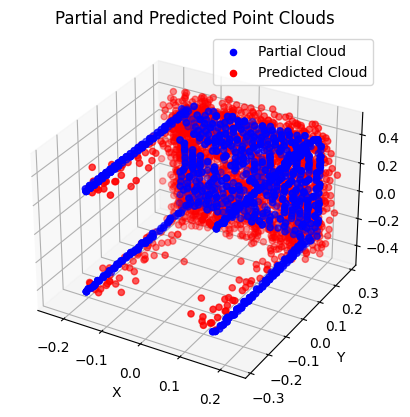

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data (replace with your actual data)
partial_cloud = test_dataset[2]  # Example partial point cloud
predicted_cloud =predicted_point_clouds[2]# Example predicted point cloud

# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot partial point cloud in blue
ax.scatter(partial_cloud[:, 0], partial_cloud[:, 1], partial_cloud[:, 2], c='b', label='Partial Cloud')

# Plot predicted point cloud in red
ax.scatter(predicted_cloud[:, 0], predicted_cloud[:, 1], predicted_cloud[:, 2], c='r', label='Predicted Cloud')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Partial and Predicted Point Clouds')

# Add legend
ax.legend()

# Show plot
plt.show()



In [58]:
np.save('test.npy' , test_dataset)